In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, multilabel_confusion_matrix
from keras.datasets import mnist
import seaborn as sns
import tensorflow as tf
import cv2
from sklearn.decomposition import PCA
import skimage.measure

# Homework 1 Submission:
## Amit Tzahar, Ravit Shagan Damti

# Loading mnist dataset:

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


# Present dataset statistics:

In [3]:
print('MNIST Dataset Statistics - Size:')
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

MNIST Dataset Statistics - Size:
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


MNIST Dataset Images Examples:


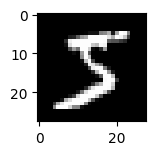

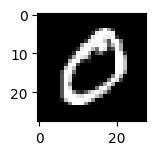

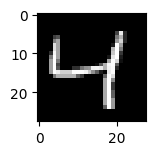

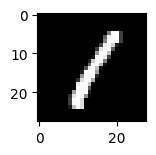

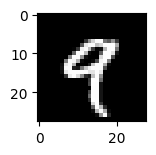

In [4]:
print('MNIST Dataset Images Examples:')
for i in range(5):
  plt.subplot(330 + 1 + i)
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
  plt.show()

# Image distribution by class:

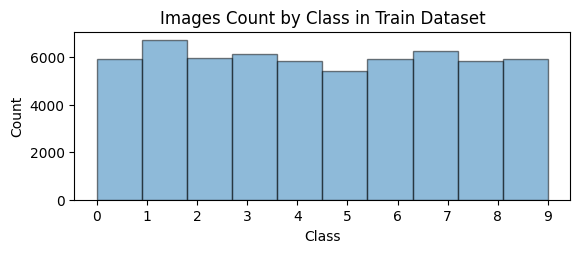

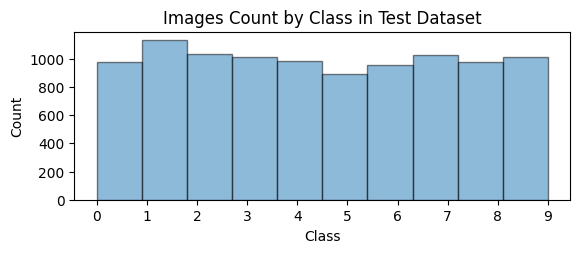

In [5]:
# classes distribution
plt.subplot(2, 1, 1)
plt.hist(y_train, alpha=0.5, histtype='bar', ec='black')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Images Count by Class in Train Dataset")
plt.show()

plt.subplot(2, 1, 2)
plt.hist(y_test, alpha=0.5, histtype='bar', ec='black')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Images Count by Class in Test Dataset")
plt.show()

The plots above demonstrate that the data distribution is quite similar across the different classes. Additionally, they show that the training and test datasets are well-balanced.

In [6]:
# count white pixels in each image:
def count_white_pixels_by_class(df, classes):
  w_pixels = []
  for i in range(0, len(df)):
      w_pixels.append(np.sum(df[i]==255))

  w_pixels_class = pd.DataFrame(data={'w_pixels': w_pixels, 'class': classes})
  w_pixels_class['class_mean'] = w_pixels_class.groupby('class')['w_pixels'].transform('mean')
  w_pixels_class['class_std'] = w_pixels_class.groupby('class')['w_pixels'].transform('std')
  return w_pixels_class

w_pixels_train = count_white_pixels_by_class(X_train, y_train)
w_pixels_class_train = w_pixels_train[['class',	'class_mean',	'class_std']].drop_duplicates()
w_pixels_test = count_white_pixels_by_class(X_test, y_test)
w_pixels_class_test = w_pixels_test[['class',	'class_mean',	'class_std']].drop_duplicates()


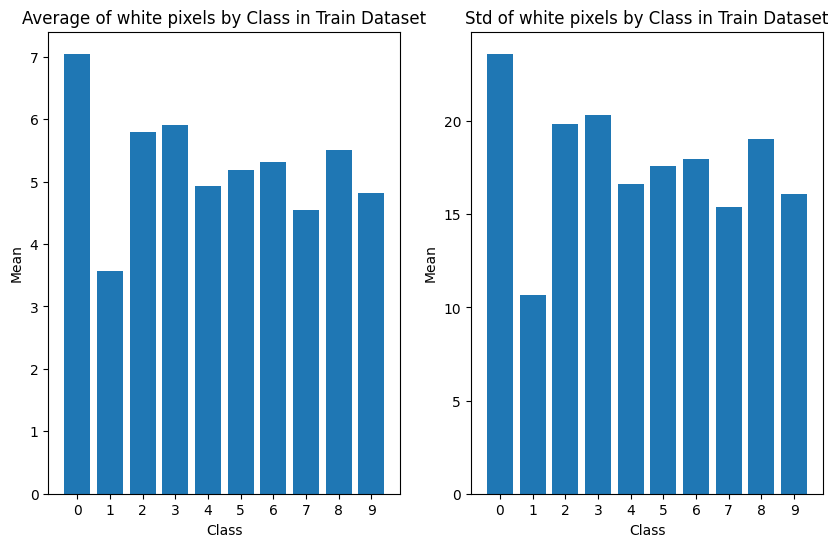

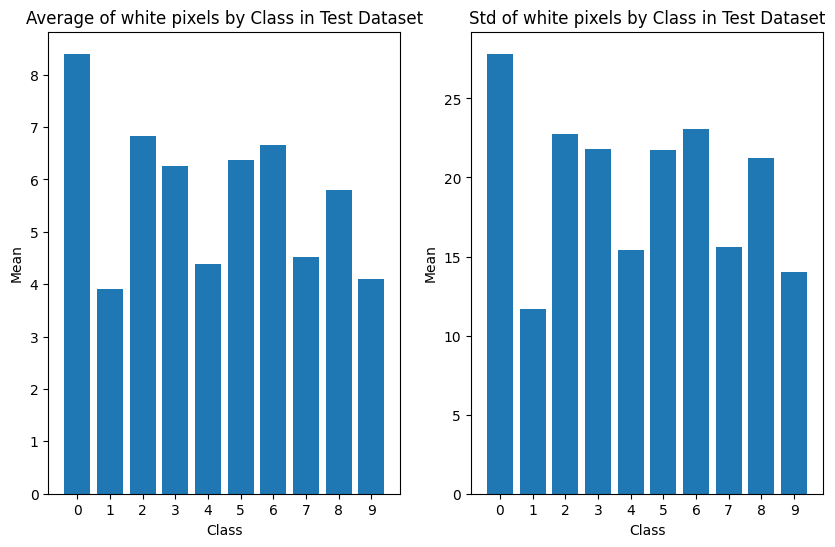

In [7]:
def plot_w_pixels_by_class(w_pixels_class, dataset):
  f, (ax1, ax2) = plt.subplots(1, 2)
  f.set_figheight(6)
  f.set_figwidth(10)
  ax1.bar(w_pixels_class['class'], w_pixels_class['class_mean'])
  ax1.set_xlabel("Class")
  ax1.set_ylabel("Mean")
  ax1.set_xticks(np.arange(0, 10, 1))
  ax1.set_title(f'Average of white pixels by Class in {dataset} Dataset')
  ax2.bar(w_pixels_class['class'], w_pixels_class['class_std'])
  ax2.set_xlabel("Class")
  ax2.set_ylabel("Mean")
  ax2.set_title(f'Std of white pixels by Class in {dataset} Dataset')
  ax2.set_xticks(np.arange(0, 10, 1))

plot_w_pixels_by_class(w_pixels_class_train, 'Train')
plot_w_pixels_by_class(w_pixels_class_test, 'Test')


The plots indicate variations in the average number of white pixels across different classes. Class 0 exhibits the highest count of white pixels and also has the highest standard deviation. These trends are consistent between the training and testing datasets.

# **Creating Neural Network**

In [8]:
# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Normalize pixel values to a range of 0 to 1
X_train, X_test = X_train / 255.0, X_test / 255.0

# Build a simple neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),  # Flatten the 28x28 images to a 1D array
    tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model summary
print(model.summary())

TensorFlow version: 2.15.0
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________________________________________

In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 15s 7ms/step - loss: 0.2826 - accuracy: 0.9157
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1209 - accuracy: 0.9639
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0894 - accuracy: 0.9737
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0702 - accuracy: 0.9783
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0577 - accuracy: 0.9814


In [10]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)

y_pred = model.predict(X_test)

313/313 - 1s - loss: 0.0825 - accuracy: 0.9760 - 565ms/epoch - 2ms/step

Test accuracy: 0.9760000109672546
313/313 [==============================] - 1s 2ms/step


# Classification Results




accuracy:  0.98  precision:  0.98  recall:  0.98  f1:  0.98  specificity:  0.99


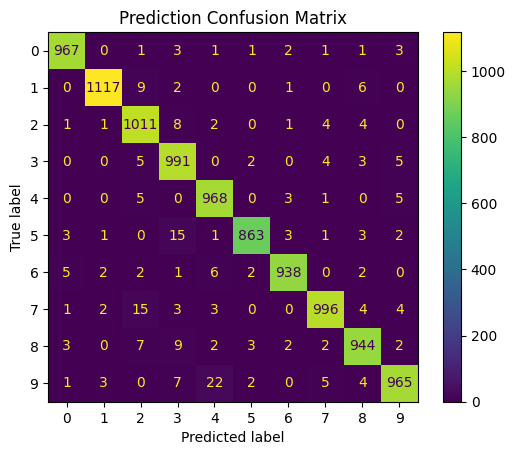

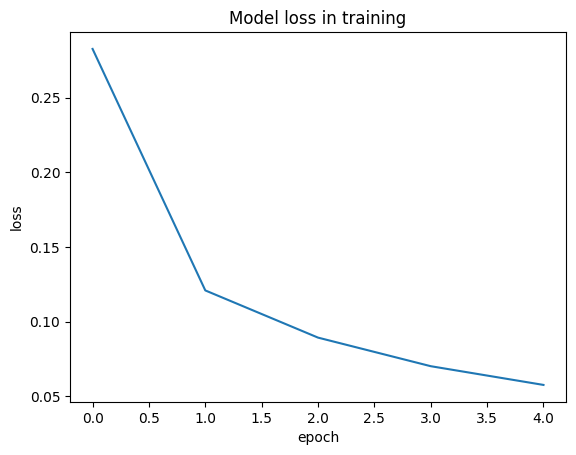

In [11]:
def print_cm(y_test, y_pred, labels, title):
    cm = confusion_matrix(y_test, y_pred)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=labels)
    cm_disp.plot()
    plt.title(title)
    plt.show()

def get_pred_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    specificity = recall_score(np.logical_not(y_test) , np.logical_not(y_pred))
    return round(accuracy,2), round(precision,2), round(recall,2), round(f1,2), round(specificity,2)

def get_loss_plot(history):
  plt.plot(history.history['loss'])
  plt.title('Model loss in training')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.show()

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy, precision, recall, f1, specificity = get_pred_metrics(y_test, y_pred_labels)
print('accuracy: ', accuracy, ' precision: ', precision, ' recall: ', recall, ' f1: ', f1, ' specificity: ', specificity)
print_cm(y_test, y_pred_labels, labels, 'Prediction Confusion Matrix')
get_loss_plot(history)

These results suggest high performance across various evaluation metrics,we can see a high level of accuracy and consistency in the model's predictions.
The confusion matrix shows that the majority of classifications are accurate, and there isn't any particular class showing lower results compared to others.
The plot of model loss shows that the optimal number of epoches is 5.

# Average Surrounding Pixel Generation: Constructing a New Dataset from Original Images

Example od image from the new dataset:


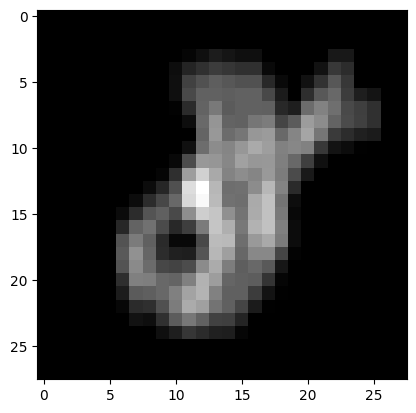

In [12]:
# New Dataset: the value of each pixel is replaced by the average of all the 3x3 surrounding pixels
X_train_blur = cv2.blur(X_train, (3,3))
y_train_blur = cv2.blur(y_train, (3,3))
X_test_blur = cv2.blur(X_test, (3,3))
y_test_blur = cv2.blur(y_test, (3,3))
# eaxmple:
print('Example od image from the new dataset:')
plt.imshow(X_train_blur[10], cmap=plt.get_cmap('gray'))
plt.show()



In [13]:
y_train_blur = y_train_blur.reshape(60000)
y_test_blur = y_test_blur.reshape(10000)

In [14]:
# Train the model
history_blur = model.fit(X_train_blur, y_train_blur, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.5539 - accuracy: 0.3450
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1.3924 - accuracy: 0.4041
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 1.3349 - accuracy: 0.4350
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 1.2924 - accuracy: 0.4546
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 1.2590 - accuracy: 0.4738


In [15]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_blur, y_test_blur, verbose=2)
print("\nTest accuracy:", test_acc)

y_pred_blur = model.predict(X_test_blur)

313/313 - 0s - loss: 1.2317 - accuracy: 0.4935 - 426ms/epoch - 1ms/step

Test accuracy: 0.4934999942779541
313/313 [==============================] - 1s 2ms/step


# Classification Results

accuracy:  0.49  precision:  0.54  recall:  0.55  f1:  0.54  specificity:  0.82


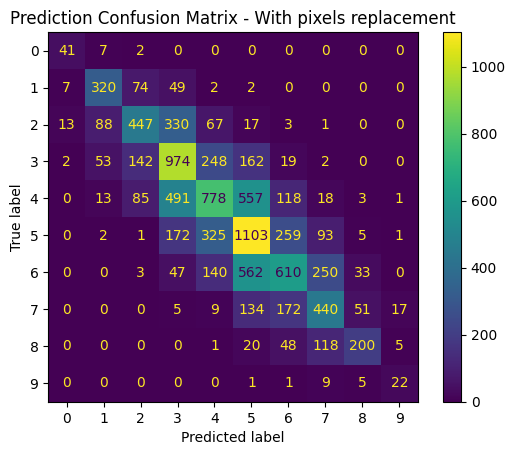

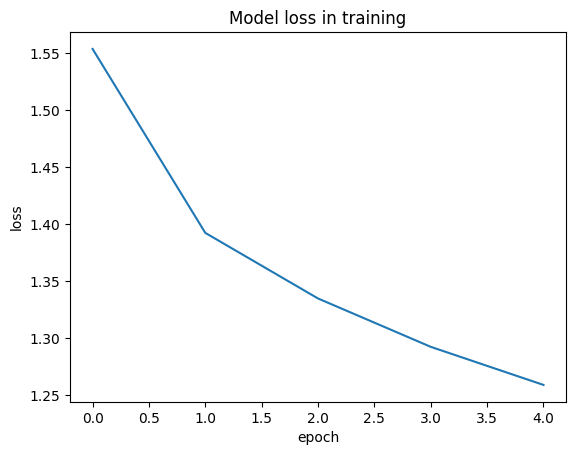

In [16]:
y_pred_labels_blur = np.argmax(y_pred_blur, axis=1)
accuracy, precision, recall, f1, specificity = get_pred_metrics(y_test_blur, y_pred_labels_blur)
print('accuracy: ', accuracy, ' precision: ', precision, ' recall: ', recall, ' f1: ', f1, ' specificity: ', specificity)
print_cm(y_test_blur, y_pred_labels_blur, labels, 'Prediction Confusion Matrix - With pixels replacement')
get_loss_plot(history_blur)

The results of the original dataset were much higher in all metrics compared to these:
- Accuracy dropped significantly from 0.98 to 0.5.
- Precision also decreased from 0.98 to 0.56, implying that 56% of positive predictions were accurate.
- Recall dropped significantly from 0.98 to 0.5.
- F1 score decreased from 0.98 to 0.52.
- Specificity decreased from 0.98 to 0.72, remains relatively higher compared to the other metrics.

Overall, these new results indicate a major decline in model performance. This is expected since the new dataset is more blurred as we saw. That's leading to the model's inability to interpret the images accurately.
The confusion matrix also support this conclusion.
The plot of model loss shows that the optimal number of epoches is 5.



# **Dimension Reduction with Principal Component Analysis (PCA)**

In [17]:
# Reshaping the dataset
X_train_pca = X_train.reshape(60000, 784)
X_test_pca = X_test.reshape(10000, 784)
# PCA:
pca = PCA(n_components=0.95)
pca.fit(X_train_pca)
print(f'Total number of components used after PCA : {pca.n_components_}')
X_train_pca = pca.transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)

print(f'train shape : {X_train_pca.shape}')
print(f'test shape : {X_test_pca.shape}')

Total number of components used after PCA : 154
train shape : (60000, 154)
test shape : (10000, 154)


In [18]:
# Build a simple neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=pca.n_components_),  # Fully connected layer with 128 units and ReLU activation, fit to new dataset size
    tf.keras.layers.Dense(64, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model summary
print(model.summary())

# Train the model
history_pca = model.fit(X_train_pca, y_train, epochs=5, batch_size=32)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               19840     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 28746 (112.29 KB)
Trainable params: 28746 (112.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3085 - accuracy: 0.9093
Epoch 2/5
1875/1875 [=====================

In [19]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_pca, y_test, verbose=2)
print("\nTest accuracy:", test_acc)

y_pred_pca = model.predict(X_test_pca)

313/313 - 1s - loss: 0.0835 - accuracy: 0.9780 - 570ms/epoch - 2ms/step

Test accuracy: 0.9779999852180481
313/313 [==============================] - 0s 1ms/step


# Classification Results

accuracy:  0.98  precision:  0.98  recall:  0.98  f1:  0.98  specificity:  0.99


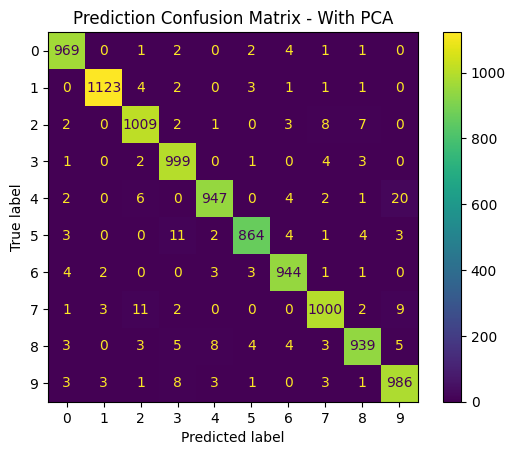

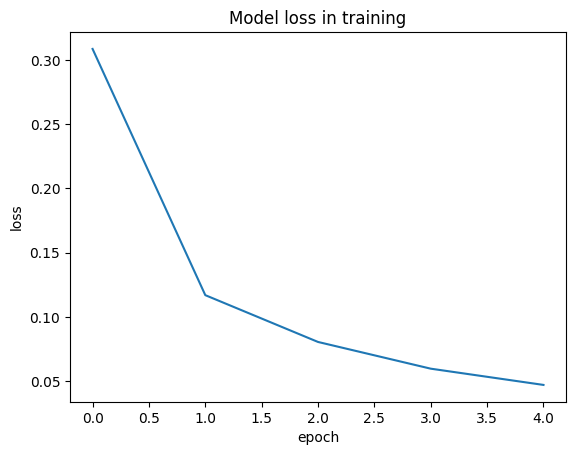

In [20]:
y_pred_labels_pca = np.argmax(y_pred_pca, axis=1)
accuracy, precision, recall, f1, specificity = get_pred_metrics(y_test, y_pred_labels_pca)
print('accuracy: ', accuracy, ' precision: ', precision, ' recall: ', recall, ' f1: ', f1, ' specificity: ', specificity)
print_cm(y_test, y_pred_labels_pca, labels, 'Prediction Confusion Matrix - With PCA')
get_loss_plot(history_pca)

After applying PCA, the results indicate high performance across vall metrics:
- Accuracy: 98% of all predictions were correct.
- Precision: 98% of the positive predictions were correct.
- Recall: 98% of the actual positives were correctly identified.
- F1 score: 98%
- Specificity: 99% of the actual negatives were correctly identified as such.

Overall, these metrics demonstrate that PCA has effectively reduced the dimensionality of the data while maintaining high model performance, resulting  accurate and reliable predictions.
We also see that there isn't a significant difference in the confusion matrix between this dataset and the original dataset, indicating the effectiveness of PCA.
The plot of model loss shows that the optimal number of epoches is 5.

# **Dimension Reduction: Average Value Replacement for Non-overlapping 3x3 Pixel Blocks - Average Pooling**

train shape : (60000, 10, 10)
test shape : (10000, 10, 10)
Image example from new dataset:


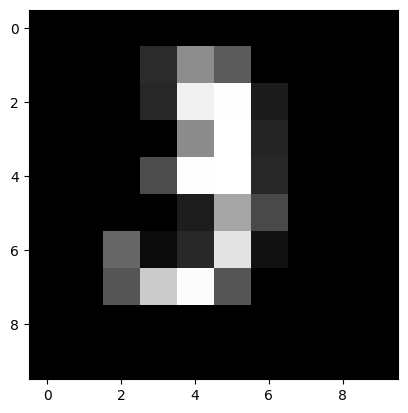

In [21]:
# New dataset with Pooling:
def img_avg_pooling(img_arr):
   img_pool = []
   for img in img_arr:
     img = skimage.measure.block_reduce(img, (3,3), np.mean)
     img_pool.append(img)
   return np.array(img_pool)

X_train_pool = img_avg_pooling(X_train)
X_test_pool = img_avg_pooling(X_test)

print(f'train shape : {X_train_pool.shape}')
print(f'test shape : {X_test_pool.shape}')

print('Image example from new dataset:')
plt.imshow(X_train_pool[10], cmap=plt.get_cmap('gray'))
plt.show()

In [22]:
# Build a simple neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(10, 10)),  # Flatten the 10x10 images to a 1D array
    tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model summary
print(model.summary())

# Train the model
history_pool = model.fit(X_train_pool, y_train, epochs=5)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               12928     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 21834 (85.29 KB)
Trainable params: 21834 (85.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5
187

In [23]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_pool, y_test, verbose=2)
print("\nTest accuracy:", test_acc)

y_pred_pool = model.predict(X_test_pool)

313/313 - 0s - loss: 0.0811 - accuracy: 0.9735 - 462ms/epoch - 1ms/step

Test accuracy: 0.9735000133514404
313/313 [==============================] - 0s 1ms/step


# Classification Results

accuracy:  0.97  precision:  0.97  recall:  0.97  f1:  0.97  specificity:  0.99


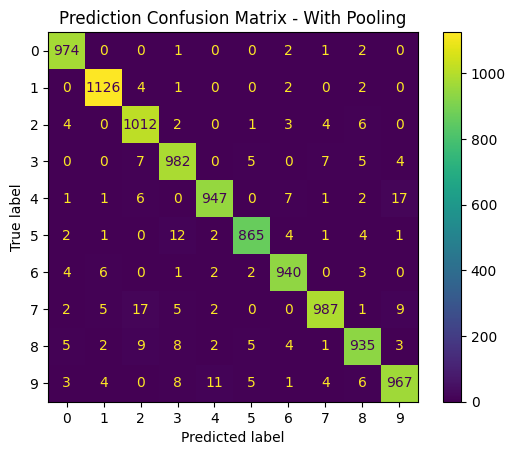

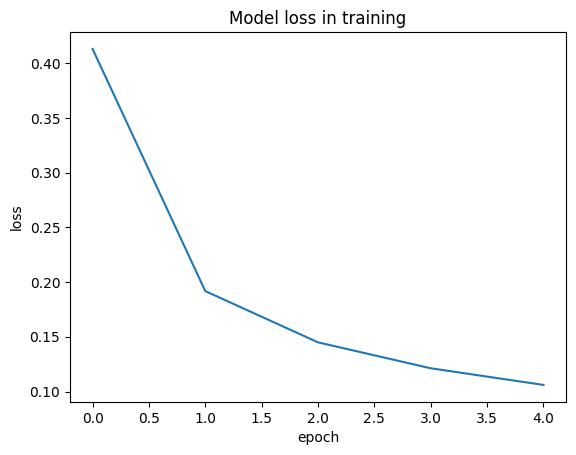

In [24]:
y_pred_labels_pool = np.argmax(y_pred_pool, axis=1)
accuracy, precision, recall, f1, specificity = get_pred_metrics(y_test, y_pred_labels_pool)
print('accuracy: ', accuracy, ' precision: ', precision, ' recall: ', recall, ' f1: ', f1, ' specificity: ', specificity)
print_cm(y_test, y_pred_labels_pool, labels, 'Prediction Confusion Matrix - With Pooling')
get_loss_plot(history_pool)

These results demonstrate a high level of performance across all evaluation metrics:

- Accuracy: 97% of all predictions were correct.
- Precision: 97% of the positive predictions were correct.
- Recall: 97% of the actual positives were correctly identified.
- F1 score: 97%.
- Specificity: 99% of the actual negatives were correctly identified as such.

Overall, these metrics reflect a well-performing model with a strong ability to correctly classify both positive and negative instances, with a slightly lower perofmance compared to previous results.

The confusion matrix also shows that classifications across all classes had good performance. This indicates that the dimension reduction did not affect the model's understanding of the dataset.

The plot of model loss shows that the optimal number of epoches is 5.

# **Compare Dimension Reduction**

The PCA results show a slight increase compared to pooling:

- Accuracy decreased from 0.98 to 0.97, indicating a 1% drop.
- Precision also decreased from 0.98 to 0.97, showing a 1% decrease in the accuracy of positive predictions.
- Recall decreased from 0.98 to 0.97, indicating a 1% decrease in the ability to correctly identify actual positives.
- F1 score decreased from 0.98 to 0.97, representing a 1% drop.
- Specificity remained the same at 0.99, indicating that 99% of actual negatives were still correctly identified.



Overall, these results suggest that PCA has a little bit better results.

Now, let's compare **dimension reduction methods to the original dataset results**:

- The PCA results show a slightly higher specificity, while the other metrics remain the same.
- The average pooling results shows a slight decrease in accuracy and related metrics compared to the original dataset, the specificity remained high.

In colclusion, comparing dimension reduction results to the original dataset results shows that applying dimension reduction did not significantly impact the overall performance of the model. The metrics remained consistent between the two datasets, indicating that PCA/Pooling successfully reduced the dimensionality of the data without compromising the model's ability to accurately classify instances. Additionally, there was a slight improvement in specificity in the PCA results, suggesting a better ability to classify negative instances. Overall, PCA appears to be better technique for reducing dimensionality while maintaining model performance.

# **Creating Imbalanced Datasets: Undersampling Two Classes**

In [25]:
# undersmapling:
l = len(y_train[y_train==7])
class_7_y = y_train[y_train==7][:(round(l/3))]
class_7_X = X_train[y_train==7][:(round(l/3))]
l = len(y_train[y_train==2])
class_2_y = y_train[y_train==2][:(round(l/3))]
class_2_X = X_train[y_train==2][:(round(l/3))]

y_train_under = np.concatenate((y_train[~(y_train!=2) | (y_train!=7)], class_2_y, class_7_y))
X_train_under = np.concatenate((X_train[~(y_train!=2) | (y_train!=7)], class_2_X, class_7_X))


In [26]:
# Build a simple neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),  # Flatten the 28x28 images to a 1D array
    tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dense(64, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# model summary
print(model.summary())

# Train the model
history_under = model.fit(X_train_under, y_train_under, epochs=5)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               100480    
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/5

In [27]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)

y_pred_under = model.predict(X_test)

313/313 - 1s - loss: 0.0894 - accuracy: 0.9750 - 880ms/epoch - 3ms/step

Test accuracy: 0.9750000238418579
313/313 [==============================] - 1s 2ms/step


# Classification Results

accuracy:  0.98  precision:  0.98  recall:  0.97  f1:  0.97  specificity:  0.99


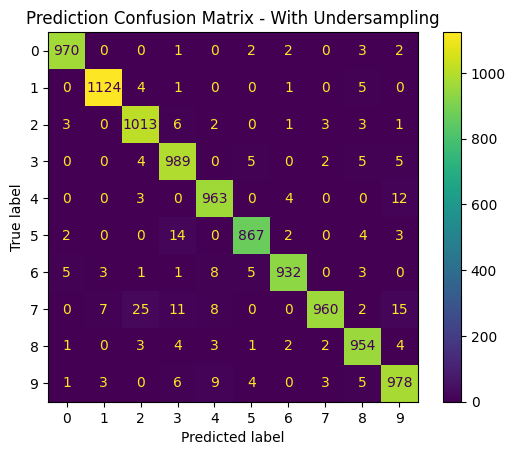

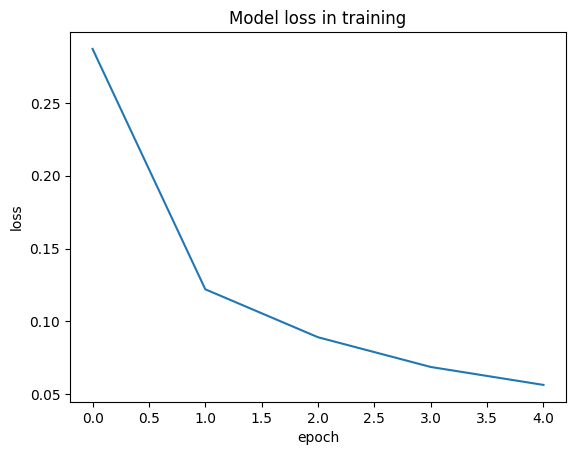

In [28]:
y_pred_labels_under = np.argmax(y_pred_under, axis=1)
accuracy, precision, recall, f1, specificity = get_pred_metrics(y_test, y_pred_labels_under)
print('accuracy: ', accuracy, ' precision: ', precision, ' recall: ', recall, ' f1: ', f1, ' specificity: ', specificity)
print_cm(y_test, y_pred_labels_under, labels, 'Prediction Confusion Matrix - With Undersampling')
get_loss_plot(history_under)

After undersampling of classes 2 and 7 by 1/3, we expected a decrease in results. However, the metrics show a well-performing model with a strong capability to accurately classify instances. The model maintains high accuracy and precision levels, compared to those of the original dataset.

The confusion matrix shows a slight decrease in the performance of classes 2 and 7 in the, demonstrating that undersampling specific classes can make it slightly harder for the model to classify them. But, this decrease is minimal and did not significantly impact the overall results.

# **Creating Imbalanced Datasets: Class Expansion through Image Manipulation**

Image example from new dataset- rotation:


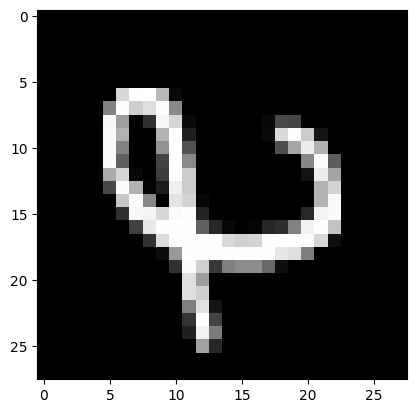

In [29]:
# rotation:
def rotate_imgs_arr(img_arr, k):
  img_rot = []
  for img in img_arr:
    img = np.rot90(img, k=k)
    img_rot.append(img)
  return np.array(img_rot)

class_7_y = y_train[y_train==7]
class_7_X = X_train[y_train==7]
class_2_y = y_train[y_train==2]
class_2_X = X_train[y_train==2]
class_7_X_rot = np.concatenate((rotate_imgs_arr(class_7_X, 3), rotate_imgs_arr(class_7_X, 2)))
class_7_y_rot = np.concatenate((class_7_y, class_7_y))
class_2_X_rot = np.concatenate((rotate_imgs_arr(class_2_X, 3), rotate_imgs_arr(class_2_X, 2)))
class_2_y_rot = np.concatenate((class_2_y, class_2_y))

y_train_aug = np.concatenate((y_train[~(y_train!=2) | (y_train!=7)], class_2_y, class_2_y_rot, class_7_y, class_7_y_rot))
X_train_aug = np.concatenate((X_train[~(y_train!=2) | (y_train!=7)], class_2_X, class_2_X_rot, class_7_X, class_7_X_rot))

print('Image example from new dataset- rotation:')
plt.imshow(class_2_X_rot[1], cmap=plt.get_cmap('gray'))
plt.show()

Image example from new dataset- shifting:


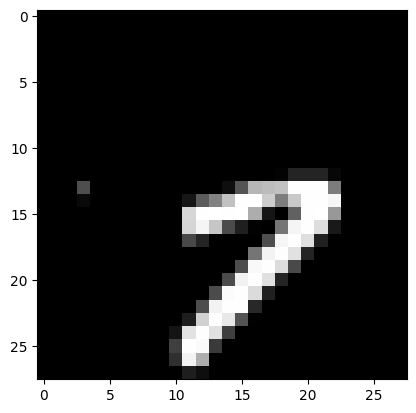

In [30]:
#shifting:
def shift_image(X, dx, dy):
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    if dy>0:
        X[:dy, :] = 0
    elif dy<0:
        X[dy:, :] = 0
    if dx>0:
        X[:, :dx] = 0
    elif dx<0:
        X[:, dx:] = 0
    return X

def shift_imgs_arr(img_arr, dx, dy):
  imgs_shift = []
  for img in img_arr:
    img = shift_image(img, dx, dy)
    imgs_shift.append(img)
  return np.array(imgs_shift)


class_7_X_shift = np.concatenate((shift_imgs_arr(class_7_X, 2,4), shift_imgs_arr(class_7_X, 3, -2)))
class_7_y_shift = np.concatenate((class_7_y, class_7_y))
class_2_X_shift = np.concatenate((shift_imgs_arr(class_2_X, 2,2), shift_imgs_arr(class_2_X, 3, -4)))
class_2_y_shift = np.concatenate((class_2_y, class_2_y))

y_train_aug = np.concatenate((y_train_aug, class_2_y, class_2_y_shift, class_7_y, class_7_y_shift))
X_train_aug = np.concatenate((X_train_aug, class_2_X, class_2_X_shift, class_7_X, class_7_X_shift))

print('Image example from new dataset- shifting:')
plt.imshow(class_7_X_shift[1], cmap=plt.get_cmap('gray'))
plt.show()


In [31]:
# Train the model
history_aug = model.fit(X_train_aug, y_train_aug, epochs=5)

Epoch 1/5
3972/3972 [==============================] - 15s 4ms/step - loss: 0.0945 - accuracy: 0.9715
Epoch 2/5
3972/3972 [==============================] - 13s 3ms/step - loss: 0.0518 - accuracy: 0.9839
Epoch 3/5
3972/3972 [==============================] - 17s 4ms/step - loss: 0.0410 - accuracy: 0.9871
Epoch 4/5
3972/3972 [==============================] - 20s 5ms/step - loss: 0.0349 - accuracy: 0.9889
Epoch 5/5
3972/3972 [==============================] - 23s 6ms/step - loss: 0.0300 - accuracy: 0.9905


In [32]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)

y_pred_aug = model.predict(X_test)

313/313 - 1s - loss: 0.0968 - accuracy: 0.9746 - 683ms/epoch - 2ms/step

Test accuracy: 0.9746000170707703
313/313 [==============================] - 1s 2ms/step


# Classification Results

accuracy:  0.97  precision:  0.97  recall:  0.97  f1:  0.97  specificity:  0.99


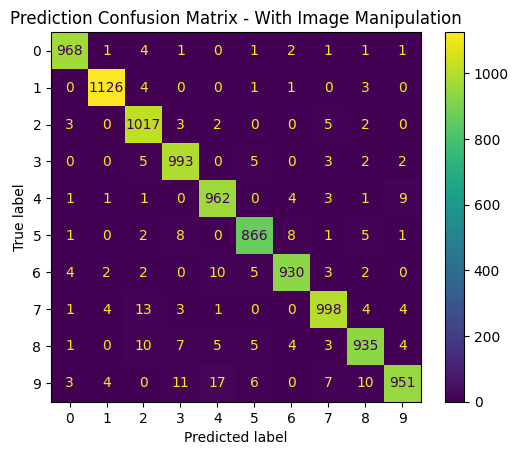

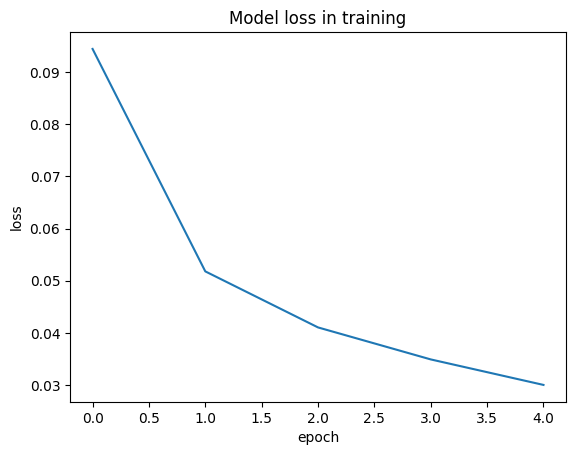

In [33]:
y_pred_labels_aug = np.argmax(y_pred_aug, axis=1)
accuracy, precision, recall, f1, specificity = get_pred_metrics(y_test, y_pred_labels_aug)
print('accuracy: ', accuracy, ' precision: ', precision, ' recall: ', recall, ' f1: ', f1, ' specificity: ', specificity)
print_cm(y_test, y_pred_labels_aug, labels, 'Prediction Confusion Matrix - With Image Manipulation')
get_loss_plot(history_aug)

The image manipulations applied to classes 2 and 7 did not significantly impact the model's results. We can see in the confusion matrix good results for classifying classes 2 and 7 but not significally different from those of the original dataset.





# **Compare Imbalanced Datasets**

Now, let's compare undersampling to image manipulation.
Both techniques maintained high accuracy, precision, recall, F1 score, and specificity, indicating that they were effective in enhancing the model's performance without significant differences between them.

But, if we will look about the two specific classes in the confusion matrix we will see that:
- undersampling has 44 FN and 29 FP of class 7
- undersampling has 21 FN and 38 FP of class 2 while 21 of them are predicted as 7
- image manipulation has 23 FN and 27 FP of class 7
- image manipulation has 26 FN and 30 FP of class 2

In summary, undersampling shows more mistakes in classes 2 and 7 and tends to confuse between these two classes, while image manipulation demonstrates better results across most metrics.


Now, let's compare **imbalanced datasets to the original results**:
- original dataset has 27 FN and 27 FP of class 7
- original dataset has 19 FN and 22 FP of class 2
That shows that there is improvement in classifying class 7 but decrease in class 2. We can conclude that this might occur because rotations can confuse the model rather than helping its understanding. However, in terms of overall performance, we didn't observe a significant change between the imbalanced datasets and the original one.
